In [1]:
import pandas as pd

In [2]:
df = pd.read_excel("./BBDD/PPG-BP Database/Table 1.xlsx")
df1 = df.iloc[:,:5]
df2 = df.iloc[:,5:10]
df2.columns=df1.columns.values
df3 = df.iloc[:,10:15]
df3.columns=df1.columns.values
df4 = df.iloc[:,15:20]
df4.columns=df1.columns.values
df_concatenado = pd.concat([df1, df2, df3, df4], axis=0, ignore_index=True)
df = df_concatenado.drop(df_concatenado.index[-1])
df = df.drop(df.columns[0], axis=1)
df['subject ID'] = df['subject ID'].astype(int)
df.columns=["subject ID","1","2","3"]
#Identificacion segmento alta calidad y creación de la columna con el nombre del archivo a escoger
df["segmento mayor calidad"] = df["subject ID"].astype(str)+"_"+df[['1', '2', '3']].idxmax(axis=1)

In [3]:
df_data = pd.read_excel("./BBDD/PPG-BP Database/Data File/PPG-BP dataset.xlsx")

df["Hypertension"]=df_data["Hypertension"]
df.head()

,subject ID,1,2,3,segmento mayor calidad,Hypertension
0,2,0.98,0.96,0.92,2_1,Stage 2 hypertension
1,3,0.69,0.80,0.81,3_3,Stage 2 hypertension
2,6,0.58,0.59,0.64,6_3,Normal
3,8,0.96,0.85,0.87,8_1,Prehypertension
4,9,0.65,0.67,0.87,9_3,Prehypertension


In [4]:
df_features = df_data[["Systolic Blood Pressure(mmHg)", "Diastolic Blood Pressure(mmHg)", "Heart Rate(b/m)"]]
df_features = df_features.loc[df_features.index.repeat(3)].reset_index(drop=True) #Multiplicamos cada fila por tres ya que se toman los tres segmentos por cada paciente

In [5]:
data_list = []

for ID in range(len(df)):
    for segment in range(3): #3 segmentos por paciente
        file_name = f'{df["subject ID"][ID]}_{(segment+1)}'
        # Leer el fichero de datos PPG de cada segmento
        data =  pd.read_csv(f"./BBDD/PPG-BP Database/Data File/0_subject/{file_name}.txt", delimiter="\t", header=None)
    
        # Añadir los datos a la lista
        data_list.append(data)

In [6]:
'''
# Si solo se quiere extraer el segmento de mayor calidad
# Lista para almacenar los datos de cada fichero
data_list = []

# Iterar sobre la columna con los nombres de los ficheros
for file_name in df['segmento mayor calidad']:
    # Leer el fichero de datos PPG (suponiendo que están en formato CSV, por ejemplo)
    data =  pd.read_csv(f"./Data File/0_subject/{file_name}.txt", delimiter="\t", header=None)
    
    # Añadir los datos a la lista
    data_list.append(data)
'''

'\n# Si solo se quiere extraer el segmento de mayor calidad\n# Lista para almacenar los datos de cada fichero\ndata_list = []\n\n# Iterar sobre la columna con los nombres de los ficheros\nfor file_name in df[\'segmento mayor calidad\']:\n    # Leer el fichero de datos PPG (suponiendo que están en formato CSV, por ejemplo)\n    data =  pd.read_csv(f"./Data File/0_subject/{file_name}.txt", delimiter="\t", header=None)\n    \n    # Añadir los datos a la lista\n    data_list.append(data)\n'

In [7]:
# Concatenar todos los ficheros en un solo DataFrame
dataset_ppg = pd.concat(data_list, axis=0)
# Restablecer el índice 
dataset_ppg.reset_index(drop=True, inplace=True)
#Como hay valores con el doble de muestras, eliminamos el exceso de señal ya que la mayoría tiene 2100 columnas -> waveform data was set to a sampling rate of 1 kHz, with 12 bits AD conversion precision
dataset_ppg = dataset_ppg.iloc[:, :2100]

dataset_ppg.to_pickle('./Datasets/China/set_China_PPG_signals.pkl')

In [8]:
#Guardamos las etiquetas si es señal PPG de paciente Normal o con Patologia
clinical_list = []

for ID in range(len(df)):
    file_name = f'{df["Hypertension"][ID]}'
    # Añadir los datos a la lista por factor de 3
    clinical_list.append(file_name)
    clinical_list.append(file_name)
    clinical_list.append(file_name)

clinical_data = pd.DataFrame(clinical_list)
labels = clinical_data.iloc[:] == 'Normal'

labels.to_pickle('./Datasets/China/labels_China_PPG_signals.pkl')

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split

# Crear un identificador de paciente (0, 1, ..., 218) para cada señal
patient_ids = np.repeat(np.arange(dataset_ppg.shape[0] // 3), 3)

# Dividir los pacientes en entrenamiento (70%), validación (15%), y prueba (15%)
train_patients, temp_patients = train_test_split(
    np.unique(patient_ids), test_size=0.3, random_state=42
)
val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.5, random_state=42
)

# Asignar cada señal a su conjunto
train_mask = np.isin(patient_ids, train_patients)
val_mask = np.isin(patient_ids, val_patients)
test_mask = np.isin(patient_ids, test_patients)

# Crear los datasets
X_train, y_train = dataset_ppg[train_mask], labels[train_mask]
X_val, y_val = dataset_ppg[val_mask], labels[val_mask]
X_test, y_test = dataset_ppg[test_mask], labels[test_mask]

X_train_features = df_features.iloc[train_mask]
X_val_features = df_features.iloc[val_mask]
X_test_features = df_features.iloc[test_mask]

# Mostrar tamaños de cada conjunto
print(f"Entrenamiento: {X_train.shape}, Validación: {X_val.shape}, Prueba: {X_test.shape}")


Entrenamiento: (459, 2100), Validación: (99, 2100), Prueba: (99, 2100)


In [10]:
X_train.to_pickle("./Datasets/China/X_train_China.pkl")
X_train_features.to_pickle("./Datasets/China/X_train_features_China.pkl")
y_train.to_pickle("./Datasets/China/y_train_China.pkl")

X_val.to_pickle("./Datasets/China/X_val_China.pkl")
X_val_features.to_pickle("./Datasets/China/X_val_features_China.pkl")
y_val.to_pickle("./Datasets/China/y_val_China.pkl")

X_test.to_pickle("./Datasets/China/X_test_China.pkl")
X_test_features.to_pickle("./Datasets/China/X_test_features_China.pkl")
y_test.to_pickle("./Datasets/China/y_test_China.pkl")



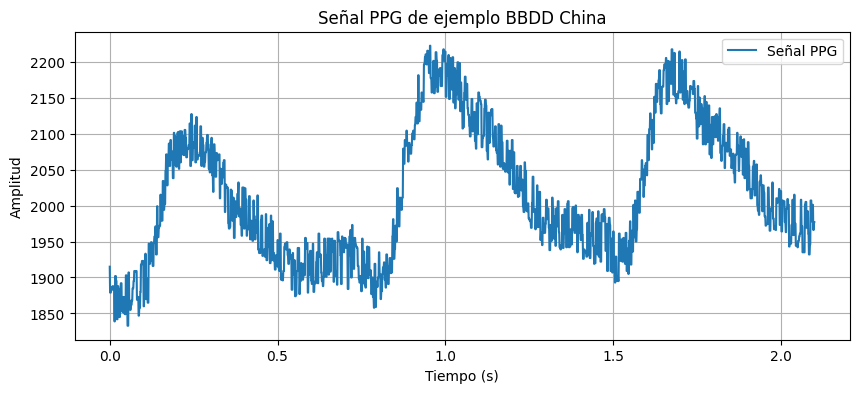

In [11]:
#Visualización de una señal del dataset
import matplotlib.pyplot as plt

# Seleccionar una señal de ejemplo
signal_example = X_train.iloc[19]  # Cambia el índice para visualizar otra señal

# Crear el eje de tiempo
sampling_rate = 1000  # Frecuencia de muestreo (Hz), asumiendo 1 kHz
time = np.linspace(0, len(signal_example) / sampling_rate, len(signal_example))

# Visualizar la señal
plt.figure(figsize=(10, 4))
plt.plot(time, signal_example, label="Señal PPG")
plt.title("Señal PPG de ejemplo BBDD China")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.legend()
plt.grid()
plt.show()
